# Hybrid Merge-Insertion Sort

### Library Imports

In [1]:
import random, time, gc, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Hybrid Merge-Insertion Sort Class

In [2]:
class HybridMISort:
    # Main sorting function
    @staticmethod
    def sort(array, S=32):
        counter = [0]
        HybridMISort.mergesort(array, 0, len(array) - 1, S, counter)
        return counter[0]
    
    #Counter functions for key comparisons
    @staticmethod
    def lessequal(a, b, counter):
        counter[0] += 1
        return a <= b
    
    @staticmethod
    def greater(a, b, counter):
        counter[0] += 1
        return a > b
    
    # Algorithms
    @staticmethod
    def mergesort(a, left, right, S, counter):
        if S > 0 and right - left + 1 <= S:
            HybridMISort.insertionsort(a, left, right, counter)
            return
        if left >= right:
            return
        mid = (left + right) // 2
        HybridMISort.mergesort(a, left, mid, S, counter)
        HybridMISort.mergesort(a, mid + 1, right, S, counter)
        HybridMISort.merge(a, left, mid, right, counter)
    
    @staticmethod
    def merge(array, left, mid, right, counter):
        n1 = mid - left + 1
        n2 = right - mid
        L = array[left:left + n1]
        R = array[mid + 1:mid + 1 + n2]
        i = j = 0
        k = left
        while i < n1 and j < n2:
            if HybridMISort.lessequal(L[i], R[j], counter): # if L[i] <= R[j]:
                array[k] = L[i]
                i += 1
            else:
                array[k] = R[j]
                j += 1
            k += 1
        while i < n1:
            array[k] = L[i]
            i += 1
            k += 1
        while j < n2:
            array[k] = R[j]
            j += 1
            k += 1

    @staticmethod
    def insertionsort(array, left, right, counter):
        for i in range(left + 1, right + 1):
            key = array[i]
            j = i - 1
            while j >= left and HybridMISort.greater(array[j], key, counter): # array[j] > key
                array[j + 1] = array[j]
                j -= 1
            array[j + 1] = key

## Array Generators

### Random Array Generator

In [3]:
def randarr(size=1000, seed=42):
    rng = random.Random(seed)
    return rng.sample(range(1, size + 1), k=size)

### Best Case Array Generator

In [4]:
def bestcase(size=1000):
    return list(range(1, size+1))

### Worst Case MergeSort Array Generator

In [5]:
def worstmerges(size=1000):
    a = list(range(1, size+1))
    def rec(xs):
        if len(xs) <= 1:
            return xs
        left  = rec(xs[1::2])
        right = rec(xs[0::2])
        return left + right
    return rec(a)

### Worst Case HybridSort Array Generator

In [6]:
def worst_case_hybrid(size, S):
    arr = worstmerges(size)
    if S > 1:
        for i in range(0, size, S):
            j = min(i+S, size)
            arr[i:j] = sorted(arr[i:j], reverse=True)
    return arr

## Experiment Functions

### Single Run Function

In [7]:
def singlerun(size, S, case="random", seed=42):
    if case == "random":
        a = randarr(size, seed)
    elif case == "best":
        a = bestcase(size)
    elif case == "worst":
        a = worst_case_hybrid(size, S)
    else:
        raise ValueError("case must be 'random', 'best', or 'worst'")

    t0 = time.perf_counter()
    comps = HybridMISort.sort(a, S=S)
    t1 = time.perf_counter()
    return comps, (t1 - t0)


### Data Collection for different array sizes with fixed S

In [8]:
def multiarray(S=32, trials=5, case="random", seed=42, fixed_array=None):
    if fixed_array is not None:
        arraysize = [10**fixed_array]
    else:
        arraysize = [10**k for k in range(3, 7)]
    rows = []
    for array in arraysize:
        comps_list, time_list = [], []
        for r in range(trials):
            comps, secs = singlerun(array, S, case=case, seed=seed+r)
            comps_list.append(comps)
            time_list.append(secs)
            gc.collect() # Clear memory otherwise crash
        rows.append({
            "Array": array,
            "S": S,
            "case": case,
            "comparisons_avg": np.mean(comps_list),
            "time_s_avg": np.mean(time_list)
        })
    return pd.DataFrame(rows)

### Data Collection for different array sizes with varying S

In [9]:
def gridsearch_array_S(trials=1, case="random", seed=42):
    S_values = range(1, 50)
    frames = [multiarray(S=S, trials=trials, case=case, seed=seed) for S in S_values]
    return pd.concat(frames, ignore_index=True)

## Theory

There are

$$
L \;=\; \left\lceil \log_2\!\frac{n}{S}\right\rceil
$$

merge levels from leaves of size $\le S$ back to size $n$. Each level touches all $n$ elements once, so the merge work is

$$
\boxed{C_{\text{merge}}(n,S) \;=\; \Theta\!\big(n\log_2(n/S)\big).}
$$


There are about $n/S$ leaves. For a leaf of size $m\le S$, insertion sort uses:
* **Best case (already sorted):** $m-1$ comparisons
* **Average (random):** $\approx \tfrac{1}{4}m(m-1)$ comparisons
* **Worst (reverse):** $\tfrac{1}{2}m(m-1)$ comparisons

Taking $m\approx S$ and summing across $\approx n/S$ leaves:
$$
\boxed{C_{\text{leaf,best}}(n,S) \;=\; \Theta(n)}
$$

$$
\boxed{C_{\text{leaf,avg}}(n,S) \;\approx\; \tfrac{1}{4}\,nS \;+\; \Theta(n)}
$$

$$
\boxed{C_{\text{leaf,worst}}(n,S) \;\approx\; \tfrac{1}{2}\,nS \;+\; \Theta(n)}
$$

Combine merge + leaves:

$$
\boxed{
\begin{aligned}
C_{\text{best}}(n,S)   &= \Theta\!\big(n\log_2(n/S)\big) + \Theta(n),\\[2pt]
C_{\text{avg}}(n,S)    &\approx n\log_2(n/S) + \tfrac{1}{4}\,nS + \Theta(n),\\[2pt]
C_{\text{worst}}(n,S)  &\approx n\log_2(n/S) + \tfrac{1}{2}\,nS + \Theta(n).
\end{aligned}}
$$

## Experiments

###
i. With the value of S fixed, plot the number of key comparisons over different sizes of the input list n. Compare your empirical results with your theoretical analysis of the time complexity.

Theory (for best/avg/worst leaves with $c \in \{0, \tfrac14, \tfrac12\}$):

$$
C(n) \;\approx\; n\log_2 n \;-\; n\log_2 S \;+\; c\,nS \;(+\text{lower order}).
$$

plot $C$  vs $n$ should be nearly flat in $n$; larger $S$ sits slightly lower due to the $-\,n\log_2 S$ shift.

In [10]:
df_i = multiarray()
df_i

,Array,S,case,comparisons_avg,time_s_avg
0,1000,32,random,13398.4,0.002784
1,10000,32,random,143301.4,0.027974
2,100000,32,random,1862005.4,0.359595
3,1000000,32,random,23187460.4,4.971382


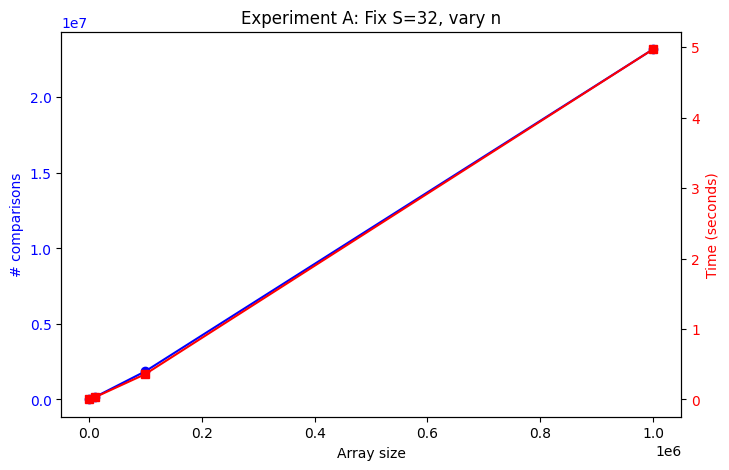

In [11]:
plt.figure(figsize=(8,5))
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot comparisons_avg on left y-axis
ax1.plot(df_i["Array"], df_i["comparisons_avg"], marker="o", color="b", label="Hybrid comparisons")
ax1.set_xlabel("Array size")
ax1.set_ylabel("# comparisons", color="b")
ax1.tick_params(axis='y', labelcolor="b")

# Plot time_s_avg on right y-axis
ax2.plot(df_i["Array"], df_i["time_s_avg"], marker="s", color="r", label="Time (s)")
ax2.set_ylabel("Time (seconds)", color="r")
ax2.tick_params(axis='y', labelcolor="r")

plt.title("Experiment A: Fix S=32, vary n")
plt.show()

###
ii. With the input size n fixed, plot the number of key comparisons over
different values of S. Compare your empirical results with your
theoretical analysis of the time complexity.


and


iii. Using different sizes of input datasets, study how to determine an
optimal value of S for the best performance of this hybrid algorithm.

Average-case model:

$$
C(S) \;\approx\; n\log_2 n \;-\; n\log_2 S \;+\; \tfrac14\,nS \;(+\Theta(n)).
$$

Competing terms $-n\log S$ (helps larger $S$) and $+\tfrac14 nS$ (hurts larger $S$) ⇒ expect a **U-shaped** curve.

In [12]:
df_ii = gridsearch_array_S(trials=5, case="random", seed=42)
df_ii

,Array,S,case,comparisons_avg,time_s_avg
0,1000,1,random,8715.6,0.002597
1,10000,1,random,120484.4,0.031951
2,100000,1,random,1536387.4,0.389896
3,1000000,1,random,18673679.4,5.041863
4,1000,2,random,8715.6,0.002338
...,...,...,...,...,...
191,1000000,48,random,23187460.4,4.792251
192,1000,49,random,13398.4,0.002558
193,10000,49,random,183161.6,0.032878
194,100000,49,random,2382465.8,0.432279


In [12]:
def plot_comparisons_vs_S(df, array=10**3):
    df_case = df[df["Array"] == array]  # Filter for the given array size
    grouped_comps = df_case.groupby("S")["comparisons_avg"].mean()
    grouped_time = df_case.groupby("S")["time_s_avg"].mean()

    plt.figure(figsize=(8,5))
    ax1 = plt.gca()
    ax2 = ax1.twinx()

    # Plot comparisons_avg on left y-axis
    ax1.plot(grouped_comps.index, grouped_comps.values, marker="o", color="b", label="Comparisons")
    ax1.set_xlabel("S (Insertion Sort Threshold)")
    ax1.set_ylabel("Average # Comparisons", color="b")
    ax1.tick_params(axis='y', labelcolor="b")

    # Plot time_s_avg on right y-axis
    ax2.plot(grouped_time.index, grouped_time.values, marker="s", color="r", label="Time (s)")
    ax2.set_ylabel("Average Time (seconds)", color="r")
    ax2.tick_params(axis='y', labelcolor="r")

    plt.title(f"Comparisons and Time vs S for Array='{array}'")
    plt.grid(True)
    plt.show()

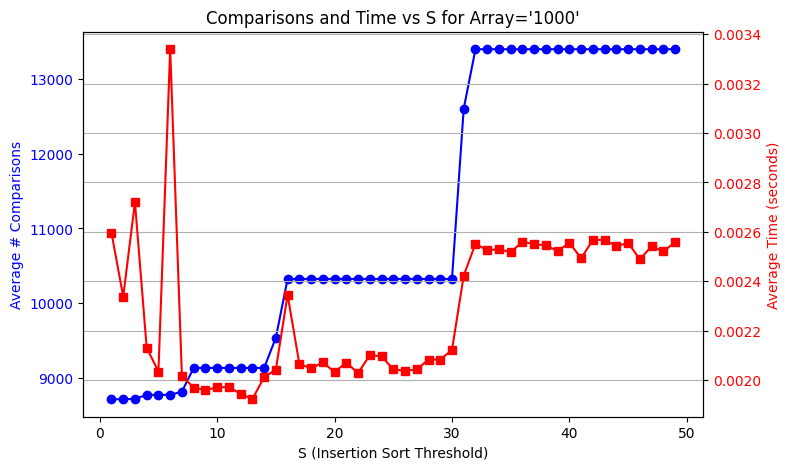

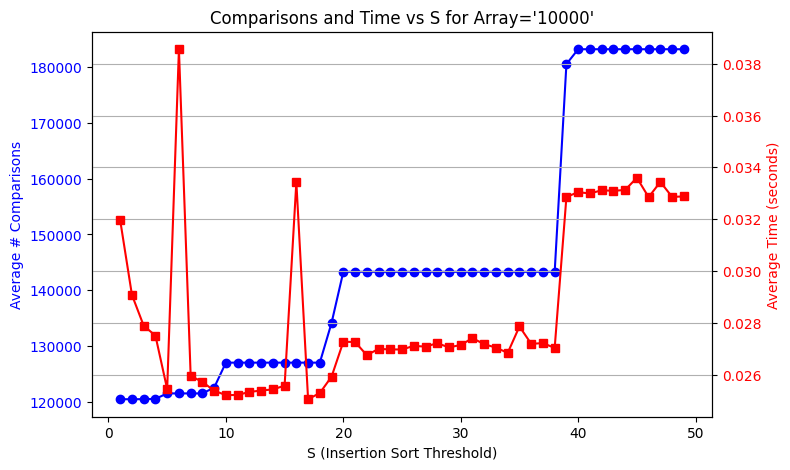

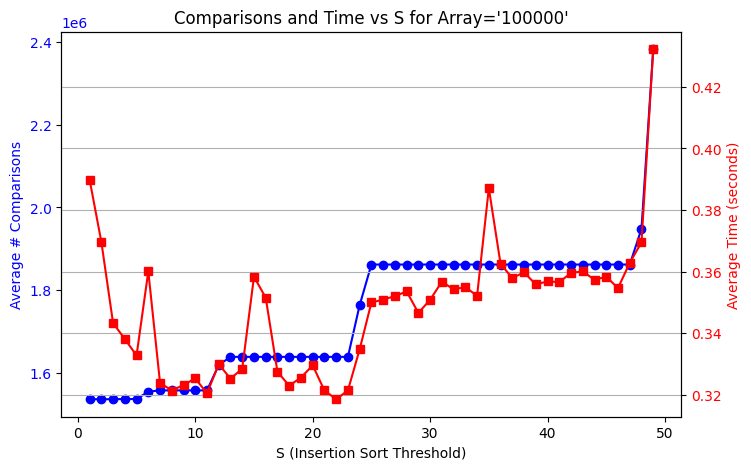

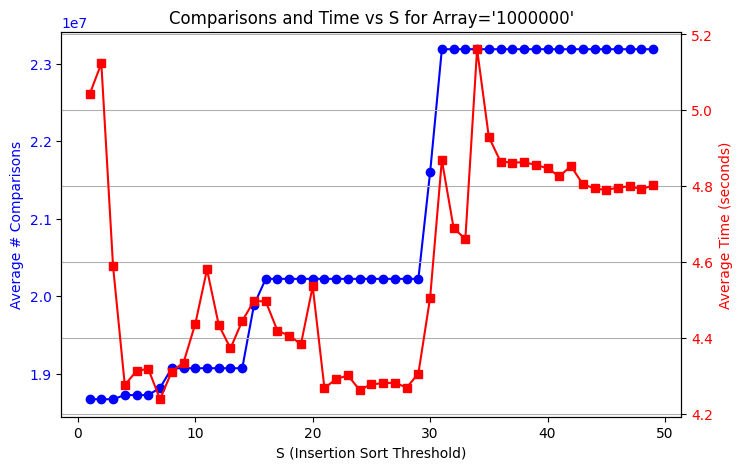

In [22]:
plot_comparisons_vs_S(df_ii, array=10**3)
plot_comparisons_vs_S(df_ii, array=10**4)
plot_comparisons_vs_S(df_ii, array=10**5)
plot_comparisons_vs_S(df_ii, array=10**6)

###
iv. Implement the original version of Mergesort (as learnt in lecture). Compare its performance against the above hybrid algorithm in terms of the number of key comparisons and CPU times on the dataset with 10 million integers. You can use the optimal value of S obtained in (c) for this task.

In [ ]:
S_values = range(1, 50)
frames = [multiarray(S=S, trials=1, fixed_array=7) for S in S_values]
merge_vs_hybrid_df = pd.concat(frames, ignore_index=True)
merge_vs_hybrid_df

,Array,S,case,comparisons_avg,time_s_avg
0,10000000,1,random,220099204.0,64.689612
1,10000000,2,random,220099204.0,61.695411
2,10000000,3,random,220098853.0,60.009333
3,10000000,4,random,220219314.0,60.429189
4,10000000,5,random,221107722.0,60.753052
5,10000000,6,random,221107722.0,63.184356
6,10000000,7,random,221107722.0,63.989163
7,10000000,8,random,221107722.0,61.697218
8,10000000,9,random,223149612.0,61.546961
9,10000000,10,random,226416436.0,62.053276


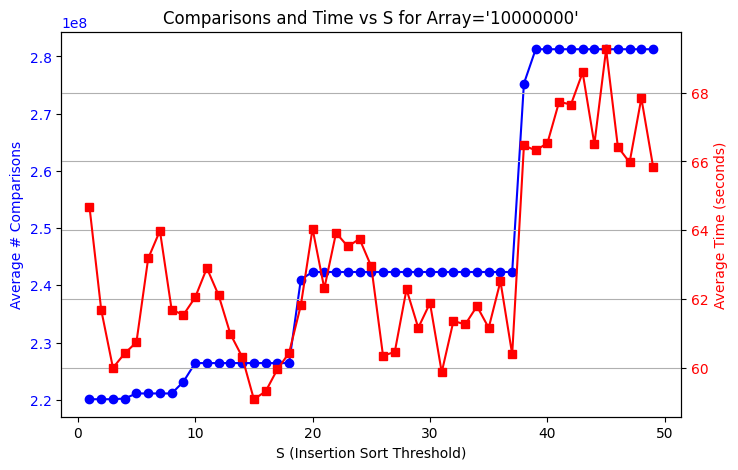

In [13]:
plot_comparisons_vs_S(merge_vs_hybrid_df, array=10**7)